In [1]:
import pandas as pd
import csv
import langid
import numpy as np
import requests
import re
import string
import nltk
import unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.probability import FreqDist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# download the Indonesian stopwords from NLTK
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('indonesian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\irfan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
# Load data
data = pd.read_csv('gabung_all.csv', encoding='utf-8')
print (data)

                                                    text     label
0      Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  negative
1      Belum jadi kok sudah mau memindahkan ASN Pak? ...  negative
2      Sampai di IKN, asn nya mengeluh...oala disini ...  negative
3      Emang ikn jadi kapan? Kayak dia masih menjabat...  negative
4      Tdk semudah itu ASN wajib pindah ke IKN tahun ...  negative
...                                                  ...       ...
12515  Kadang gimana gitu y pak, \nJadi ngerasa bener...  positive
12516  DPR secara institusi sudah menyetujui IKN yg t...  positive
12517  #2022JokowiSelesai Ikn,Nusantara,Bp \n@jokowi\...  positive
12518  Sejarah besar ....\nBalap motor GP Mandalika\n...  positive
12519  Bapak, Saya merantau ke Jakarta dr Jateng thn ...  positive

[12520 rows x 2 columns]


In [4]:
# Cek apakah 'case_folding' ada dalam dataframe
if 'text' in data.columns:
    # Ambil kolom 'case_folding' dari dataframe
    kolom_case_folding = data['text']
    
    # Fungsi untuk memisahkan hashtag
    def pisahkan_hashtag(kalimat):
        # Menggunakan regex untuk mencocokkan pola hashtag
        pola = r'#[A-Za-z0-9_]+'
        hasil = re.findall(pola, kalimat)
        
        # Mengganti hashtag dengan kata terpisah
        for hashtag in hasil:
            kata_terpisah = re.sub(r'([a-z])([A-Z])', r'\1 \2', hashtag)
            kalimat = kalimat.replace(hashtag, kata_terpisah)
        
        return kalimat

    # Memisahkan hashtag pada setiap kalimat dalam kolom 'case_folding'
    data['pisah_hashtag&kata'] = kolom_case_folding.apply(pisahkan_hashtag)
    
    # Cetak dataframe untuk memverifikasi hasilnya
    print(data)
else:
    print("Kolom 'case_folding' tidak ada dalam dataframe.")

                                                    text     label  \
0      Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  negative   
1      Belum jadi kok sudah mau memindahkan ASN Pak? ...  negative   
2      Sampai di IKN, asn nya mengeluh...oala disini ...  negative   
3      Emang ikn jadi kapan? Kayak dia masih menjabat...  negative   
4      Tdk semudah itu ASN wajib pindah ke IKN tahun ...  negative   
...                                                  ...       ...   
12515  Kadang gimana gitu y pak, \nJadi ngerasa bener...  positive   
12516  DPR secara institusi sudah menyetujui IKN yg t...  positive   
12517  #2022JokowiSelesai Ikn,Nusantara,Bp \n@jokowi\...  positive   
12518  Sejarah besar ....\nBalap motor GP Mandalika\n...  positive   
12519  Bapak, Saya merantau ke Jakarta dr Jateng thn ...  positive   

                                      pisah_hashtag&kata  
0      Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...  
1      Belum jadi kok sudah mau memindahk

In [5]:
# Menyimpan hasil identifikasi ke dalam file CSV
data.to_csv("hasil/handling_hashtag.csv", index=False)

In [6]:
data['pisah_hashtag&kata']

0        Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...
1        Belum jadi kok sudah mau memindahkan ASN Pak? ...
2        Sampai di IKN, asn nya mengeluh...oala disini ...
3        Emang ikn jadi kapan? Kayak dia masih menjabat...
4        Tdk semudah itu ASN wajib pindah ke IKN tahun ...
                               ...                        
12515    Kadang gimana gitu y pak, \nJadi ngerasa bener...
12516    DPR secara institusi sudah menyetujui IKN yg t...
12517    #2022Jokowi Selesai Ikn,Nusantara,Bp \n@jokowi...
12518    Sejarah besar ....\nBalap motor GP Mandalika\n...
12519    Bapak, Saya merantau ke Jakarta dr Jateng thn ...
Name: pisah_hashtag&kata, Length: 12520, dtype: object

In [7]:
# Import corpus dari nltk
from nltk.tokenize import word_tokenize

# Fungsi untuk menghapus tanda baca menggunakan regex
def hapus_tanda_baca(kata):
    return re.sub(r'[^\w\s-]', '', kata)

# Fungsi untuk melakukan preprocessing pada kolom teks
def preprocess_text(text):

    # Menghapus karakter non-ASCII
    text = remove_non_ascii(text)

    # Remove URLs, mentions, and hashtags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\@\w+|\#', '', text)

    # Tokenisasi kalimat menjadi kata-kata
    kata_kata = word_tokenize(text)

    # Menghapus tanda baca dari setiap kata
    kata_kata_tanpa_tanda_baca = [hapus_tanda_baca(kata) for kata in kata_kata]

    # Menggabungkan kata-kata kembali menjadi kalimat
    kalimat_tanpa_tanda_baca = ' '.join(kata_kata_tanpa_tanda_baca)

    # Menggantikan tanda baca dengan spasi tunggal menggunakan regex
    kalimat_final = re.sub(r'(?<=[^\w\s-])', ' ', kalimat_tanpa_tanda_baca)

    # Menggantikan multiple spasi dengan satu spasi menggunakan regex
    kalimat_tanpa_spasi_ganda = re.sub(r'\s+', ' ', kalimat_final)

    # Remove special characters and digits
    kalimat_tanpa_tanda_baca_dan_digit = re.sub(r'[^\w\s-]', '', kalimat_tanpa_spasi_ganda)
    kalimat_tanpa_digit = re.sub(r'\d+', '', kalimat_tanpa_tanda_baca_dan_digit)

    # Convert to lowercase
    kalimat_final = kalimat_tanpa_digit.lower()

    # Remove whitespace leading & trailing
    kalimat_final = kalimat_final.strip()

    # Remove single char
    kalimat_final = re.sub(r"\b[a-zA-Z]\b", "", kalimat_final)

    return kalimat_final

def remove_non_ascii(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text) if unicodedata.category(c) != 'Mn')

# Melakukan preprocessing pada kolom teks
data['text_cleaning'] = data['pisah_hashtag&kata'].apply(preprocess_text)

# NLTK word rokenize 
def word_tokenize_wrapper(text):
    return word_tokenize(text)

data['tweet_tokens'] = data['text_cleaning'].apply(word_tokenize_wrapper)

print('Tokenizing Result : \n') 
print(data['tweet_tokens'].head())
print('\n\n\n')

Tokenizing Result : 

0    [lho, dia, yg, minta, ikn, kok, otorita, di, b...
1    [belum, jadi, kok, sudah, mau, memindahkan, as...
2    [sampai, di, ikn, asn, nya, mengeluh, oala, di...
3    [emang, ikn, jadi, kapan, kayak, dia, masih, m...
4    [tdk, semudah, itu, asn, wajib, pindah, ke, ik...
Name: tweet_tokens, dtype: object






In [8]:
# Menyimpan hasil identifikasi ke dalam file CSV
data.to_csv("hasil/Tweet_all.csv", index=False)

In [9]:
# Memuat data leksikon positif dan negatif
lexicon_positive = dict()
with open('lexicon_positive.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_positive[row[0]] = int(row[1])

lexicon_negative = dict()
with open('lexicon_negative.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)  # melewati baris header
    for row in reader:
        lexicon_negative[row[0]] = int(row[1])

# Daftar kata-kata positif dan negatif
positive_words = list(lexicon_positive.keys())
negative_words = list(lexicon_negative.keys())

# Fungsi untuk menentukan polaritas sentimen dari tweet        
def sentiment_analysis_lexicon_indonesia(text):
    score = 0
    positive_found = []
    negative_found = []
    for word in text:
        if word in lexicon_positive:
            score += lexicon_positive[word]
            positive_found.append((word, lexicon_positive[word]))
        if word in lexicon_negative:
            score += lexicon_negative[word]
            negative_found.append((word, lexicon_negative[word]))
    polarity = ''
    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'
    return score, polarity, positive_found, negative_found

# Asumsi `data` adalah DataFrame yang Anda miliki
# Contoh: data = pd.read_csv('your_input_file.csv')

# Hasil dari menentukan polaritas sentimen dari tweet
results = data['tweet_tokens'].apply(sentiment_analysis_lexicon_indonesia)
results = list(zip(*results))
data['polarity_score'] = results[0]
data['polarity'] = results[1]
data['positive_words'] = results[2]
data['negative_words'] = results[3]

# Menyimpan hasil ke file CSV
output_columns = ['tweet_tokens', 'polarity_score', 'polarity', 'positive_words', 'negative_words']

print(data['polarity'].value_counts())

negative    8311
positive    3115
neutral     1094
Name: polarity, dtype: int64


In [10]:
# Export to csv file
data.to_csv('hasil/Hasil_tweets_data.csv', index = False, header = True,index_label=None)

data

,text,label,pisah_hashtag&kata,text_cleaning,tweet_tokens,polarity_score,polarity,positive_words,negative_words
0,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",negative,"Lho!!!! Dia Yg Minta IKN , Kok Otorita. Di Beb...",lho dia yg minta ikn kok otorita di bebani ya ...,"[lho, dia, yg, minta, ikn, kok, otorita, di, b...",0,neutral,"[(minta, 2), (ya, 4)]","[(dia, -3), (minta, -3)]"
1,Belum jadi kok sudah mau memindahkan ASN Pak? ...,negative,Belum jadi kok sudah mau memindahkan ASN Pak? ...,belum jadi kok sudah mau memindahkan asn pak y...,"[belum, jadi, kok, sudah, mau, memindahkan, as...",0,neutral,"[(jadi, 1), (sudah, 3), (mau, 5), (memindahkan...","[(jadi, -2), (sudah, -2), (mau, -1), (memindah..."
2,"Sampai di IKN, asn nya mengeluh...oala disini ...",negative,"Sampai di IKN, asn nya mengeluh...oala disini ...",sampai di ikn asn nya mengeluh oala disini bar...,"[sampai, di, ikn, asn, nya, mengeluh, oala, di...",7,positive,"[(sampai, 2), (kerja, 2), (biasa, 2), (dengar,...","[(sampai, -4), (kena, -3), (biasa, -4), (suara..."
3,Emang ikn jadi kapan? Kayak dia masih menjabat...,negative,Emang ikn jadi kapan? Kayak dia masih menjabat...,emang ikn jadi kapan kayak dia masih menjabat ...,"[emang, ikn, jadi, kapan, kayak, dia, masih, m...",-5,negative,"[(jadi, 1), (aja, 1), (ada, 4)]","[(jadi, -2), (kayak, -3), (dia, -3), (ada, -3)]"
4,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,negative,Tdk semudah itu ASN wajib pindah ke IKN tahun ...,tdk semudah itu asn wajib pindah ke ikn tahun ...,"[tdk, semudah, itu, asn, wajib, pindah, ke, ik...",-7,negative,"[(pindah, 1), (siap, 1), (banget, 1)]","[(itu, -2), (wajib, -2), (pindah, -3), (sombon..."
...,...,...,...,...,...,...,...,...,...
12515,"Kadang gimana gitu y pak, \nJadi ngerasa bener...",positive,"Kadang gimana gitu y pak, \nJadi ngerasa bener...",kadang gimana gitu pak jadi ngerasa bener bui...,"[kadang, gimana, gitu, pak, jadi, ngerasa, ben...",-12,negative,"[(kadang, 3), (jadi, 1), (bener, 3), (liat, 2)...","[(jadi, -2), (ngerasa, -2), (bener, -1), (kata..."
12516,DPR secara institusi sudah menyetujui IKN yg t...,positive,DPR secara institusi sudah menyetujui IKN yg t...,dpr secara institusi sudah menyetujui ikn yg t...,"[dpr, secara, institusi, sudah, menyetujui, ik...",4,positive,"[(sudah, 3), (presiden, 3), (jadi, 1), (setuju...","[(sudah, -2), (melaksanakan, -3), (jadi, -2), ..."
12517,"#2022JokowiSelesai Ikn,Nusantara,Bp \n@jokowi\...",positive,"#2022Jokowi Selesai Ikn,Nusantara,Bp \n@jokowi...",jokowi selesai ikn nusantara bp akan sangat ma...,"[jokowi, selesai, ikn, nusantara, bp, akan, sa...",-19,negative,"[(selesai, 2), (sangat, 3), (mampu, 2), (harap...","[(selesai, -4), (sangat, -5), (mampu, -4), (se..."
12518,Sejarah besar ....\nBalap motor GP Mandalika\n...,positive,Sejarah besar ....\nBalap motor GP Mandalika\n...,sejarah besar balap motor gp mandalika terbent...,"[sejarah, besar, balap, motor, gp, mandalika, ...",3,positive,"[(besar, 4), (sudah, 3)]","[(besar, -2), (sudah, -2)]"


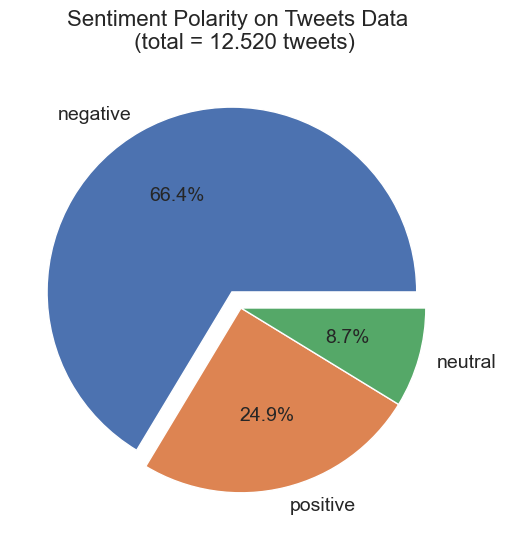

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
fig, ax = plt.subplots(figsize=(6, 6))

sizes = [count for count in data['polarity'].value_counts()]
labels = list(data['polarity'].value_counts().index)
explode = [0.1 if i == 0 else 0 for i in range(len(sizes))]  # set explode values based on index

ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', explode=explode, textprops={'fontsize': 14})
ax.set_title('Sentiment Polarity on Tweets Data \n (total = 12.520 tweets)', fontsize=16, pad=20)

plt.savefig('hasil/polarity.png')
plt.show()
plt.close()

In [13]:
pd.set_option('display.max_colwidth', 3000)
positive_tweets = data[data['polarity'] == 'positive']
positive_tweets = positive_tweets[['text_cleaning', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=False).reset_index(drop = True)
positive_tweets.index += 1
positive_tweets

,text_cleaning,polarity_score,polarity
1,gokil nih ri sama seluruh gubernur kayanya mau persami di calon ikn apakah mereka akan menyalakan api unggun lalu menyanyikan lagu api kita sudah menyala api api api api api aaaaapiii kita sudah menyala,25,positive
2,csr ga sebesar itu juga keleus ada batasan nya bisnis ikn itu ga viable di liat dr sisi manapun elo pinter tapi ke blinger mada gak mudah aja ga bs elo liat dr perspektif yg jernih cinta sama sosok boleh bego jgn,24,positive
3,yg utama ikn masih di nkri dan budaya nkri tetap terjaga para pendatang dn pemuja budaya timur tengah silahkan kalian ke timur tengah monggo nkri dgn budayanya tetap beradaptasi tnp ada kalian,24,positive
4,ketum parpol bicara penundaan pemilu di sebut demokrasi boleh bicara apa aja trus giliran emak tni polri bicara ikn baru di wa group gak boleh enak bener ya mengartikan demokrasi sesuai dengan kepentingan syahwat berkuasa,23,positive
5,selamat bertugas kepala dan wakil ikn semoga berjalan lancar dan amanah sukses buat bapak presiden jokowi dan saya doakan selalu di lindungi dan diberkati oleh tuhan yg maha kuasaaamin,23,positive
...,...,...,...
3111,aku asn pemda luar jawa mau dong mutasi ke kementerian biar pindah ke ikn,1,positive
3112,banser aja kerahkan ke ikn,1,positive
3113,maaf ikn butuh dana besar masak di rebus aja,1,positive
3114,ketika sudah pindah ke ikn mungkin bakal terjadi sesuatu di jawa,1,positive


In [14]:
pd.set_option('display.max_colwidth', 3000)
negative_tweets = data[data['polarity'] == 'negative']
negative_tweets = negative_tweets[['text_cleaning', 'polarity_score', 'polarity']].sort_values(by = 'polarity_score', ascending=True)[0:10].reset_index(drop = True)
negative_tweets.index += 1
negative_tweets[0:10]

,text_cleaning,polarity_score,polarity
1,urus minyak goreng bbm saja tidak becus negara indonesia sudah miskin diakibatkan hutang korupsi mafia tanah mafia pajak buzzer harun masiku dan yg lainnya pindah ibu kota bukan keadaan darurat apalagi membangun ikn adalah pihak swasta negara harus bayar sewa kpda swasta,-57,negative
2,rakyat sedang dicuci otaknya dengan narasi narasi dungu oleh para pejabat csnya semua amburadul akibat ketidak becusan ketidakmampuan rezim ini bekerja mengatasi semua yang ada semua maunya diborong dan tak satupun yang memuaskan rakyat dari sembako sampai ikn nol,-50,negative
3,egois itu kalau - maksa ikn - maksa pemilu ditunda - maksa kereta cepat jakarta bandung - maksa rakyat bayar pajak - maksa vaksin - maksa daftar bpjs dll silahkan tambahin sendiri saking banyaknya yang mau ditulis,-48,negative
4,darurat macet dan banjir yang mengakibatkan harus memperpanjang masa jabatan sehingga proyek pemindahan ikn dapat dikawal sampai selesai setelah itu nanti darurat hutang negara sehingga harus ditambah lagi jadi periode agar hutang selesai,-48,negative
5,yang mimpin ikn orang jawa juga ternyata kira saya putra daerah kalimantan maafkan saya sebagai orang jawa karena suku adalah warisan yang tidak bisa saya tolak berbeda dengan agama agama bukanlah warisan karena orang bisa memilih dan berpindah agama,-47,negative
6,ritual yang berujung kekacauan ternyata pejabat dan para gubernur kompak mendirikan ikn ngeri tiba airnya menjadi air mata rakyat air mata penyesalan dan tanah yang dimiliki aseng yang lebih parah masalah minyak goreng nanti dibahas habis kemping rakyat tidak penting,-46,negative
7,serba repot kalau pakek investor asing dibilang berbahaya tidak berdaulat harus pake bumn kebanyakan hutang dsb lha itu delegasi ksa berkunjung utk invest di ikn gimana matanya cuma dua tapi yg dipake cuma seperempat,-46,negative
8,usualan itu bebas usul kpk percepat tangani laporan korupsi usul batalkan ikn usul usut proyek kereta cepat bdg-jkt usul suruh mereka bayar utang negara usul sblm negara bangkrut periksa semua proyek heheheheee khan usulan aja realisasinya nanti,-46,negative
9,wkwkkw lawak emg di negeri penyamun klo korupsi sekarang berita nya ga seberapa menjual mending bahas radikal radikul lagi booming dan menjual berita nya berita ikn ketutup radikal radikul berita minyak goreng ketutup berita wayang,-46,negative
10,saya kira pemindahan ikn sudah tepat dan saya kira yang menolak itu hanya cari cari alasan dan yang menolak itu hanya orang yang memang tidak suka ikn di kalimantan dan orang orang itu selalu menolak kebijakan presiden,-45,negative


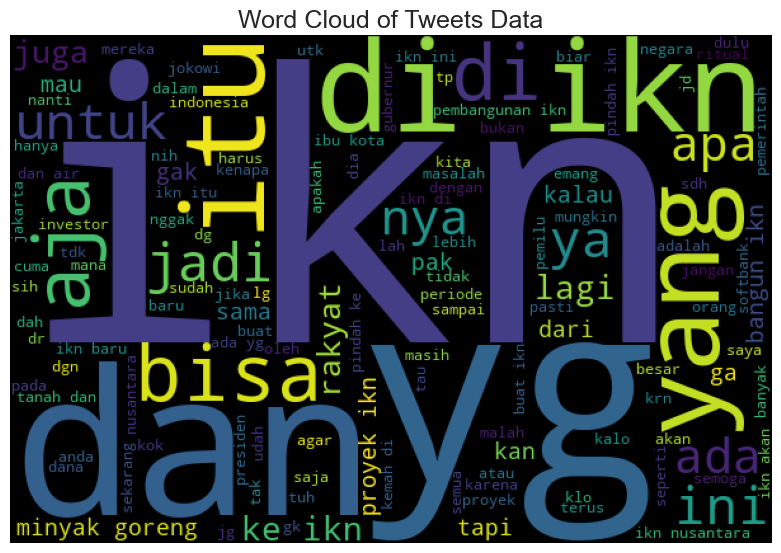

In [15]:
# Visualize word cloud
from wordcloud import WordCloud
list_words=''
for tweet in data['tweet_tokens']:
    for word in tweet:
        list_words += ' '+(word)
        
wordcloud = WordCloud(width = 600, height = 400, min_font_size = 10).generate(list_words)
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_title('Word Cloud of Tweets Data', fontsize = 18)
ax.grid(False)
ax.imshow((wordcloud))
fig.tight_layout(pad=0)
ax.axis('off')
plt.savefig('hasil/wordcloud.png')
plt.show()

In [16]:
# Function to group all positive/negative words
def words_with_sentiment(text):
    positive_words=[]
    negative_words=[]
    for word in text:
        score_pos = 0
        score_neg = 0
        if (word in lexicon_positive):
            score_pos = lexicon_positive[word]
        if (word in lexicon_negative):
            score_neg = lexicon_negative[word]
        
        if (score_pos + score_neg > 0):
            positive_words.append(word)
        elif (score_pos + score_neg < 0):
            negative_words.append(word)
            
    return positive_words, negative_words

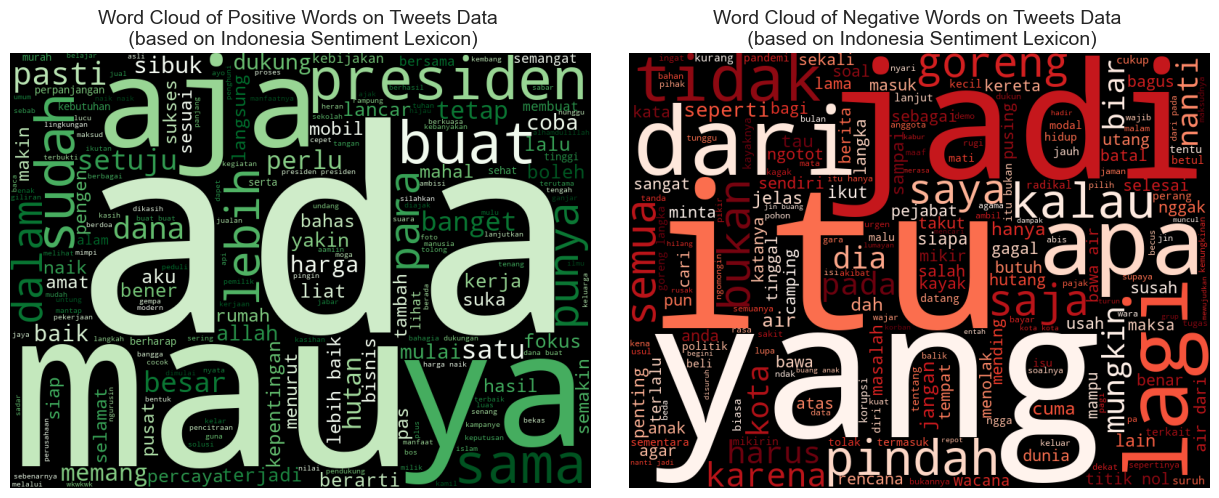

In [17]:
# Visualize positive and negative word cloud

sentiment_words = data['tweet_tokens'].apply(words_with_sentiment)
sentiment_words = list(zip(*sentiment_words))
positive_words = sentiment_words[0]
negative_words = sentiment_words[1]

fig, ax = plt.subplots(1, 2,figsize = (12, 10))
list_words_postive=''
for row_word in positive_words:
    for word in row_word:
        list_words_postive += ' '+(word)
wordcloud_positive = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Greens'
                               , min_font_size = 10).generate(list_words_postive)
ax[0].set_title('Word Cloud of Positive Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[0].grid(False)
ax[0].imshow((wordcloud_positive))
fig.tight_layout(pad=0)
ax[0].axis('off')

list_words_negative=''
for row_word in negative_words:
    for word in row_word:
        list_words_negative += ' '+(word)
wordcloud_negative = WordCloud(width = 800, height = 600, background_color = 'black', colormap = 'Reds'
                               , min_font_size = 10).generate(list_words_negative)
ax[1].set_title('Word Cloud of Negative Words on Tweets Data \n (based on Indonesia Sentiment Lexicon)', fontsize = 14)
ax[1].grid(False)
ax[1].imshow((wordcloud_negative))
fig.tight_layout(pad=0)
ax[1].axis('off')
plt.savefig('hasil/wordcloud_positif_negatif.png')
plt.show()